In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

## **Import Libraries**

In [2]:
import re
import nltk
import spacy
import time
import pandas as pd
import numpy as np
import warnings
import xgboost as xgb
import matplotlib.pyplot as plt
from nltk import FreqDist
from tabulate import tabulate
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBC

warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'nltk'

In [ ]:
nltk.download('punkt', force=True)
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## **Load Dataset**

#### **Describe some data samples**

In [ ]:
the_onion_path = "/content/drive/MyDrive/Colab Notebooks/Sarcasm_Detection/datasets/train/theonion.com.txt"
nytimes_path = "/content/drive/MyDrive/Colab Notebooks/Sarcasm_Detection/datasets/train/nytimes.com.txt"

In [ ]:
df_onion = pd.read_csv(the_onion_path, delimiter="|", names=["Headline", "Link", "Label"])
df_onion.head(5)

,Headline,Link,Label
0,Conclusive Series Of Diagnostic Tests Determin...,https://www.theonion.com/conclusive-series-of-...,1
1,Celebrity Designers Describe Their Home Declut...,https://www.theonion.com/celebrity-designers-d...,1
2,Texas Valedictorian Goes Off-Script To Condemn...,https://www.theonion.com/texas-valedictorian-g...,1
3,Kyrsten Sinema Defends Senate Filibuster As Ne...,https://www.theonion.com/kyrsten-sinema-defend...,1
4,All The Biggest Changes To ‘Final Fantasy VII ...,https://www.theonion.com/all-the-biggest-chang...,1


In [ ]:
df_nytimes = pd.read_csv(nytimes_path, delimiter="|", names=["Headline", "Link", "Label"], on_bad_lines='skip')
df_nytimes.head(5)

,Headline,Link,Label
0,"Glum to Gleeful, Israeli Media React to Possib...",https://www.nytimes.com/2021/05/31/world/middl...,0.0
1,Serena Williams Wins in the First Round at the...,https://www.nytimes.com/2021/05/31/sports/tenn...,0.0
2,Illinois Lawmakers Bar Police From Using Decep...,https://www.nytimes.com/2021/05/31/us/Chicago-...,0.0
3,With the Candlestick in the Study,https://www.nytimes.com/2021/05/31/crosswords/...,0.0
4,How Do Animals Safely Cross a Highway? Take a ...,https://www.nytimes.com/interactive/2021/05/31...,0.0


#### **Load Training Dataset**

In [ ]:
train_data_path = "/content/drive/MyDrive/Colab Notebooks/Sarcasm_Detection/datasets/train.csv"

In [ ]:
df_train = pd.read_csv(train_data_path)

df_train = df_train.sample(frac= 1).reset_index(drop= True)

# check data contains null values
print(df_train.isnull().sum())
df_train.head(5)

Headline    1
Link        0
Label       0
dtype: int64


,Headline,Link,Label
0,Onion Social CEO Embarks On Tour Of Several Co...,https://www.theonion.com/onion-social-ceo-emba...,1
1,'Garbage strike' and candle-lit vigils as Myan...,https://www.theguardian.com/world/2021/mar/30/...,0
2,People Who Moved To Texas From California Fina...,https://babylonbee.com/news/people-who-moved-t...,1
3,Rights and freedom Gaza damage and Glasgow rai...,https://www.theguardian.com/global-development...,0
4,Ex-Justice Department Official Hits Trump With...,https://www.huffpost.com/entry/neal-katyal-tru...,0


In [ ]:
# remove missing values
df_train = df_train.dropna(how= 'any')


# check data contains null values
print(df_train.isnull().sum())
df_train.head(5)

Headline    0
Link        0
Label       0
dtype: int64


,Headline,Link,Label
0,Onion Social CEO Embarks On Tour Of Several Co...,https://www.theonion.com/onion-social-ceo-emba...,1
1,'Garbage strike' and candle-lit vigils as Myan...,https://www.theguardian.com/world/2021/mar/30/...,0
2,People Who Moved To Texas From California Fina...,https://babylonbee.com/news/people-who-moved-t...,1
3,Rights and freedom Gaza damage and Glasgow rai...,https://www.theguardian.com/global-development...,0
4,Ex-Justice Department Official Hits Trump With...,https://www.huffpost.com/entry/neal-katyal-tru...,0


**Training data evaluation**

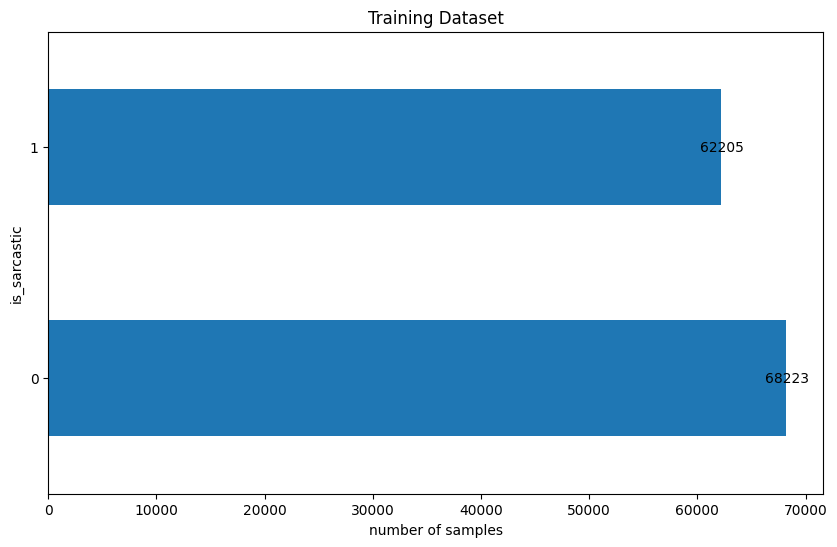

In [ ]:
ax = df_train["Label"].value_counts().plot(kind="barh", figsize=(10, 6))

for i in ax.patches:
    ax.annotate(
        f"{i.get_width():.0f}",
        (i.get_width() + 50, i.get_y() + i.get_height() / 2),
        ha="center",
        va="center",
    )

plt.xlabel("number of samples")
plt.ylabel("is_sarcastic")
plt.title("Training Dataset")
plt.show()

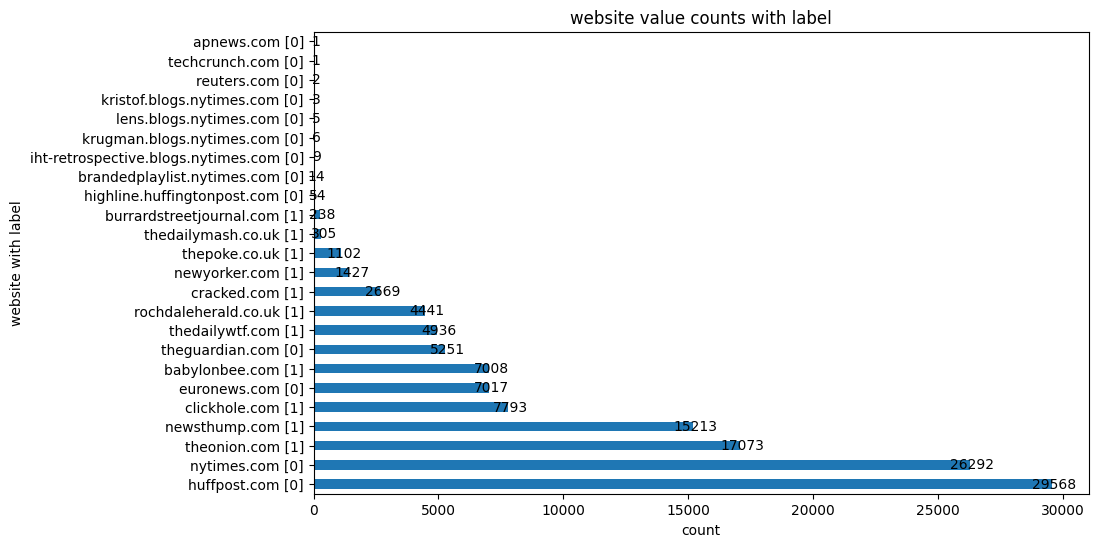

In [ ]:
# check website from Link and Label
def get_website(article_link, label):
    return article_link.split("/")[2].replace("www.", "") + " [" + str(label) + "]"


df_train["website"] = df_train.apply(
    lambda x: get_website(x.get("Link"), x.get("Label")), axis=1
)
ax = df_train["website"].value_counts().plot(kind="barh", figsize=(10, 6))

for i in ax.patches:
    ax.annotate(
        f"{i.get_width():.0f}",
        (i.get_width() + 100, i.get_y() + i.get_height() / 2),
        ha="center",
        va="center",
    )

plt.xlabel("count")
plt.ylabel("website with label")
plt.title("website value counts with label")
plt.show()


#### **Load Test Dataset**

In [ ]:
test_data_path = "/content/drive/MyDrive/Colab Notebooks/Sarcasm_Detection/datasets/test.csv"

In [ ]:
df_test = pd.read_csv(test_data_path)

# check data contains null values or not
print(df_test.isnull().sum())
df_test.head(5)

Headline    1
Link        0
Label       0
dtype: int64


,Headline,Link,Label
0,Why the COVID-19 Variants Spreading in India A...,https://time.com/5959057/india-covid-19-variants,0
1,"To Solve Disordered Migration, Governments Nee...",https://time.com/5963576/mexico-tree-planting-...,0
2,Indias COVID-19 Crisis Is Spiraling Out of Con...,https://time.com/5964796/india-covid-19-failure,0
3,"In His Speech to Congress, Joe Biden Sets Out ...",https://time.com/5995109/biden-congress-speech...,0
4,The Indian Government Is Silencing Critics Eve...,https://time.com/6005847/india-government-sile...,0


In [ ]:
# remove missing value
df_test = df_test.dropna(how= 'any')

# check data contains null values or not
print(df_test.isnull().sum())
df_test.head(5)

Headline    0
Link        0
Label       0
dtype: int64


,Headline,Link,Label
0,Why the COVID-19 Variants Spreading in India A...,https://time.com/5959057/india-covid-19-variants,0
1,"To Solve Disordered Migration, Governments Nee...",https://time.com/5963576/mexico-tree-planting-...,0
2,Indias COVID-19 Crisis Is Spiraling Out of Con...,https://time.com/5964796/india-covid-19-failure,0
3,"In His Speech to Congress, Joe Biden Sets Out ...",https://time.com/5995109/biden-congress-speech...,0
4,The Indian Government Is Silencing Critics Eve...,https://time.com/6005847/india-government-sile...,0


**Test data evaluation**

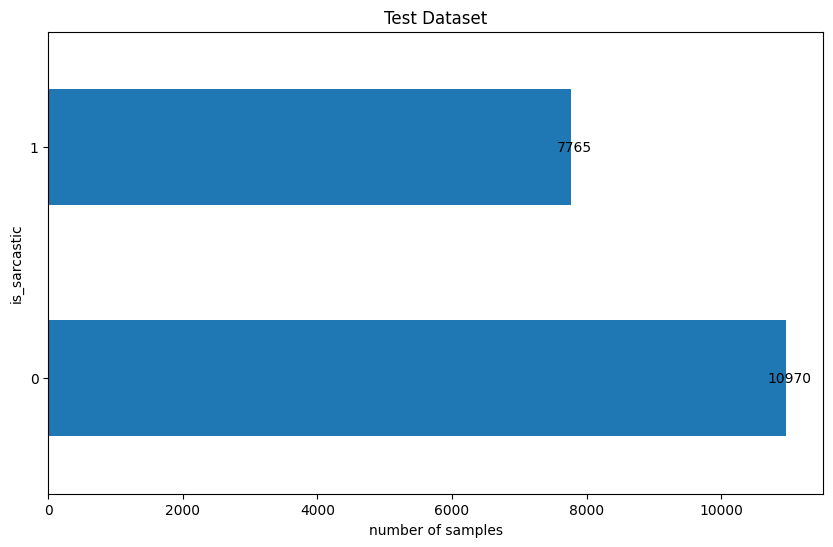

In [ ]:
ax = df_test["Label"].value_counts().plot(kind="barh", figsize=(10, 6))

for i in ax.patches:
    ax.annotate(
        f"{i.get_width():.0f}",
        (i.get_width() + 50, i.get_y() + i.get_height() / 2),
        ha="center",
        va="center",
    )

plt.xlabel("number of samples")
plt.ylabel("is_sarcastic")
plt.title("Test Dataset")
plt.show()

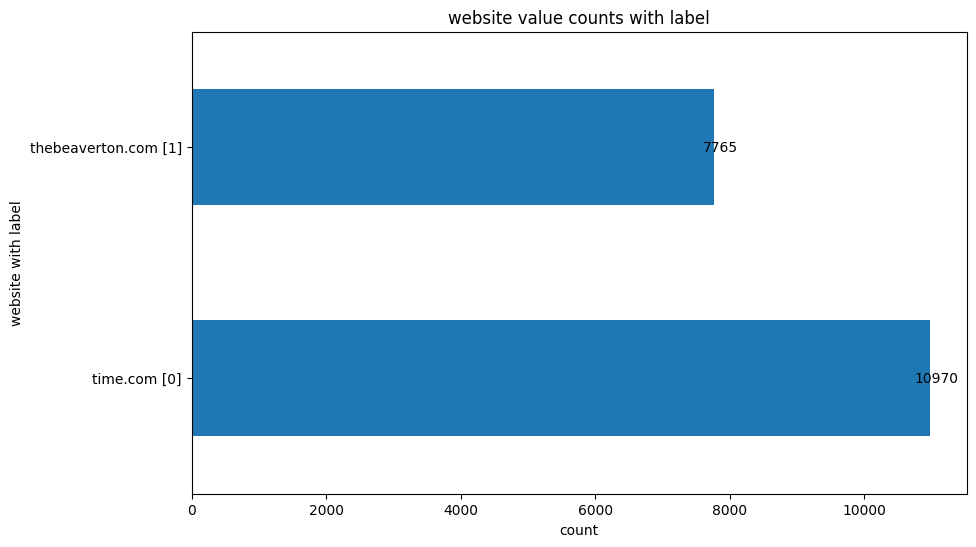

In [ ]:
# check website from Link and Label
def get_website(article_link, label):
    return article_link.split("/")[2].replace("www.", "") + " [" + str(label) + "]"


df_test["website"] = df_test.apply(
    lambda x: get_website(x.get("Link"), x.get("Label")), axis=1
)
ax = df_test["website"].value_counts().plot(kind="barh", figsize=(10, 6))

for i in ax.patches:
    ax.annotate(
        f"{i.get_width():.0f}",
        (i.get_width() + 100, i.get_y() + i.get_height() / 2),
        ha="center",
        va="center",
    )

plt.xlabel("count")
plt.ylabel("website with label")
plt.title("website value counts with label")
plt.show()

## **Pre-Processing Data**

In [ ]:
# training data
df_train_new = df_train[["Headline", "Label"]].copy()

# test data
df_test_new = df_test[["Headline", "Label"]].copy()

def remove_special_character(text):
    text = text.lower()
    text = re.sub("[^0-9a-z ]", '', text)
    return text

# Sử dụng .loc để gán giá trị vào các cột
df_train_new.loc[:, "Headline"] = df_train_new["Headline"].apply(remove_special_character)
df_test_new.loc[:, "Headline"] = df_test_new["Headline"].apply(remove_special_character)

In [ ]:
# review training data
df_train_new.head(10)

,Headline,Label
0,onion social ceo embarks on tour of several co...,1
1,garbage strike and candlelit vigils as myanmar...,0
2,people who moved to texas from california fina...,1
3,rights and freedom gaza damage and glasgow rai...,0
4,exjustice department official hits trump with ...,0
5,trump unfairly claims credit for rise in econo...,1
6,fda gives food corporations 3 years to elimina...,1
7,nyc losing residents,1
8,a new era donald trump just whispered hope you...,1
9,icelandic volcano dormant for 6000 years blows...,0


In [ ]:
# review test data
df_test_new.head(10)

,Headline,Label
0,why the covid19 variants spreading in india ar...,0
1,to solve disordered migration governments need...,0
2,indias covid19 crisis is spiraling out of cont...,0
3,in his speech to congress joe biden sets out a...,0
4,the indian government is silencing critics eve...,0
5,a major rights group says israel is guilty of ...,0
6,long before raiding rudy giulianis home invest...,0
7,what bidens first 100 days tells us about the ...,0
8,it isnt just modi indias compliant media must ...,0
9,hong kong is testing out a vaccine passport fo...,0


**Review the frequency of Corpus**

In [ ]:
# create corpus from all headlines
corpus = " ".join(df_train_new["Headline"])

# split the corpus into individual words by spaces
corpus = corpus.split(" ")

# check the frequency of words
frequency_distribution = FreqDist(corpus)

# get top 20 frequency
frequency_distribution.most_common(20)

[('to', 42592),
 ('the', 32152),
 ('of', 27356),
 ('in', 23572),
 ('a', 19341),
 ('for', 17108),
 ('and', 14000),
 ('on', 12283),
 ('', 8868),
 ('trump', 8860),
 ('with', 8644),
 ('is', 8500),
 ('as', 7207),
 ('new', 6847),
 ('at', 6816),
 ('after', 6051),
 ('from', 5853),
 ('you', 5266),
 ('by', 5247),
 ('that', 5100)]

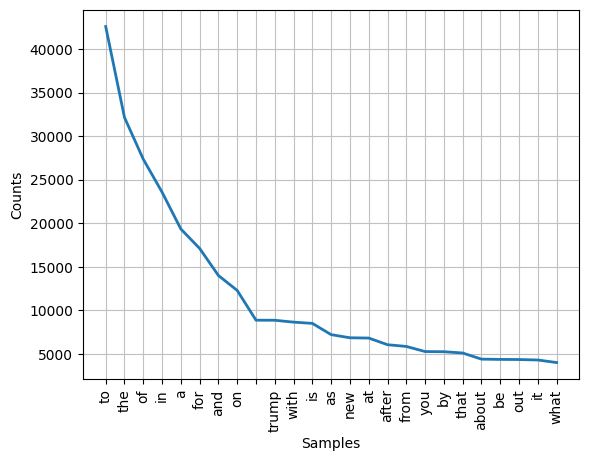

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
frequency_distribution.plot(25)

**In the above visualization, we realize that the most common words are prepositions or definte article (the, a,...), so we conduct to remove these words**

In [ ]:
# tokenize
x_train_nltk = []
for header in df_train_new["Headline"]:
    x_train_nltk.append(word_tokenize(header))

x_test_nltk = []
for header in df_test_new["Headline"]:
    x_test_nltk.append(word_tokenize(header))

In [ ]:
# create stop words from nltk
sw_nltk = set(stopwords.words("english"))

en = spacy.load("en_core_web_sm")
sw_spacy = en.Defaults.stop_words
stop_words = list(set(sw_nltk) | set(sw_spacy))

print(stop_words)

["isn't", 'ever', 'i', 'seem', 'theirs', 'hers', 'when', 'my', 'anything', '’s', 'shouldn', 'something', 'how', 'thereafter', 'any', 'whereupon', '’re', 'even', 'thereby', 'if', 'for', 'get', 'an', 'too', 'am', 'side', 'than', 'third', 'perhaps', 'which', 's', 'not', 'beforehand', 'a', 'else', 'nevertheless', 'me', 'mightn', "should've", 'fifty', 'amongst', 'further', 'take', 'from', 'therein', 'this', "that'll", 'latterly', 'the', 'within', 'it', 'as', 'but', 'could', 'four', 'indeed', 'put', 'eight', 'herself', 'yourselves', 've', 'every', 'wherever', 'twelve', 'has', '‘ve', "you'd", 'about', 'who', 'hundred', '’d', 'd', 'same', 'down', 'much', 'each', 'being', "you're", 'bottom', 'with', 'nor', 'give', 'least', 'seemed', 'thru', 'full', 'few', 'those', 'here', 'forty', 'us', 'had', "'ll", 'wouldn', 'of', 'doesn', 't', 'does', 'neither', 'toward', 'its', 'herein', 'weren', 'through', 'make', 'n’t', 'amount', "hasn't", 'below', 'together', 'have', 'y', 'serious', 'meanwhile', 'moreove

In [ ]:
filtered_train_lst = []
fileter_test_lst = []

# remove stop words in train data
for words_in_quote in x_train_nltk:
    filtered_train_sent = []
    for word in words_in_quote:
        if word not in stop_words:
            filtered_train_sent.append(word)
    filtered_train_lst.append(filtered_train_sent)

# remove stop words in test data
for words_in_quote in x_test_nltk:
    filtered_test_sent = []
    for word in words_in_quote:
        if word not in stop_words:
            filtered_test_sent.append(word)
    fileter_test_lst.append(filtered_test_sent)

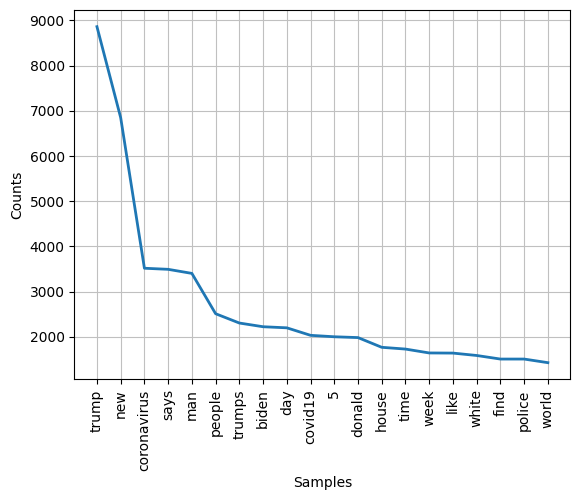

In [ ]:
# check training dataset after remove stop words
corpus = " ".join(map(str, filtered_train_lst))

corpus = re.sub("[^0-9a-z ]", '', corpus)
corpus = corpus.split()

frequency_distribution = FreqDist(corpus)

# Vẽ biểu đồ tần suất
frequency_distribution.plot(20)
plt.show()

In [ ]:
# Steming
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
x_train_stemming = []
x_test_stemming = []

# stemiming on train data
for sent_filtered in filtered_train_lst:
    sent_stemming = []
    for word in sent_filtered:
        sent_stemming.append(stemmer.stem(word))
    x_train_stemming.append(sent_stemming)

# stemming on test data
for sent_filtered in fileter_test_lst:
    sent_stemming = []
    for word in sent_filtered:
        sent_stemming.append(stemmer.stem(word))
    x_test_stemming.append(sent_stemming)

In [ ]:
for sent in x_train_stemming[:20]:
    print(sent)

['onion', 'social', 'ceo', 'embark', 'tour', 'coffe', 'shop', 'near', 'live', 'learn', 'everyday', 'american']
['garbag', 'strike', 'candlelit', 'vigil', 'myanmar', 'death', 'toll', 'pass', '500']
['peopl', 'move', 'texa', 'california', 'final', 'feel', 'home', 'power']
['right', 'freedom', 'gaza', 'damag', 'glasgow', 'raid', 'human', 'right', 'fortnight', 'pictur']
['exjustic', 'depart', 'offici', 'hit', 'trump', 'realiti', 'check', 'law', 'come']
['trump', 'unfairli', 'claim', 'credit', 'rise', 'econom', 'inequ', 'occur', 'obama', 'watch']
['fda', 'give', 'food', 'corpor', '3', 'year', 'elimin', 'tran', 'fat']
['nyc', 'lose', 'resid']
['new', 'era', 'donald', 'trump', 'whisper', 'hope', 'like', 'ham', 'motherfuck', 'white', 'hous', 'chef']
['iceland', 'volcano', 'dormant', '6000', 'year', 'blow', 'near', 'reykjavik']
['north', 'carolina', 'judg', 'step', 'suprem', 'court', 'refus']
['miss', 'file', 'amaz', 'print', 'driver', 'support', 'stori']
['fox', 'news', 'launch', '24hour', 'ro

**create Train-Test data after pre-processing data**

In [ ]:
x_train_nltk, y_train = x_train_stemming, df_train_new['Label']
x_test_nltk, y_test = x_test_stemming, df_test_new['Label']

In [ ]:
# format data to List[str]
x_train_nltk = [" ".join(sent) for sent in x_train_stemming]
x_test_nltk = [" ".join(sent) for sent in x_test_stemming]
x_train_nltk[:10]

['onion social ceo embark tour coffe shop near live learn everyday american',
 'garbag strike candlelit vigil myanmar death toll pass 500',
 'peopl move texa california final feel home power',
 'right freedom gaza damag glasgow raid human right fortnight pictur',
 'exjustic depart offici hit trump realiti check law come',
 'trump unfairli claim credit rise econom inequ occur obama watch',
 'fda give food corpor 3 year elimin tran fat',
 'nyc lose resid',
 'new era donald trump whisper hope like ham motherfuck white hous chef',
 'iceland volcano dormant 6000 year blow near reykjavik']

## **Training Model**

In [ ]:
# split train, test data
x_train, y_train = x_train_nltk, y_train
x_test, y_test = x_test_nltk, y_test

print(f"Train data has {len(x_train)} records.")
print(f"Test data has {len(x_test)} records.")

Train data has 130428 records.
Test data has 18735 records.


#### **Multinomial Naive Bayes**

In [ ]:
start_time = time.time()
clf_NB = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", MultinomialNB()),
    ]
)
clf_NB.fit(x_train, y_train)
end_time = time.time()

print(f"Training time: {end_time - start_time}")

# predict
y_pred = clf_NB.predict(x_test)

Training time: 1.6906991004943848


In [ ]:
f1_score_NB = f1_score(y_test, y_pred)
accuracy_score_NB = accuracy_score(y_test, y_pred)
precision_score_NB = precision_score(y_test, y_pred)
recall_score_NB = recall_score(y_test, y_pred)

print(f"F1 Score: {f1_score_NB}")
print(f"Accuracy Score: {accuracy_score_NB}")
print(f"Precision Score: {precision_score_NB}")
print(f"Recall Score: {recall_score_NB}")

F1 Score: 0.6885621796601025
Accuracy Score: 0.7535094742460635
Precision Score: 0.7227806880928784
Recall Score: 0.657437218287186


#### **SGD Classifier**

In [ ]:
start_time = time.time()
clf_SGD = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", SGDClassifier()),
    ]
)
clf_SGD.fit(x_train, y_train)
end_time = time.time()

print(f"Training time: {end_time - start_time}")

# predict
y_pred = clf_SGD.predict(x_test)

Training time: 1.6119399070739746


In [ ]:
f1_score_SGD = f1_score(y_test, y_pred)
accuracy_score_SGD = accuracy_score(y_test, y_pred)
precision_score_SGD = precision_score(y_test, y_pred)
recall_score_SGD = recall_score(y_test, y_pred)

print(f"F1 Score: {f1_score_SGD}")
print(f"Accuracy Score: {accuracy_score_SGD}")
print(f"Precision Score: {precision_score_SGD}")
print(f"Recall Score: {recall_score_SGD}")

F1 Score: 0.708420320111343
Accuracy Score: 0.7539898585535095
Precision Score: 0.6962198458095001
Recall Score: 0.7210560206052801


#### **Gradient Boosting**

In [ ]:
start_time = time.time()
clf_GBC = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", GBC(
            n_estimators= 100,
            max_depth= 10
        )),
    ]
)
clf_GBC.fit(x_train, y_train)
end_time = time.time()

print(f"Training time: {end_time - start_time}")

# predict
y_pred = clf_GBC.predict(x_test)

Training time: 220.93923425674438


In [ ]:
f1_score_GBC = f1_score(y_test, y_pred)
accuracy_score_GBC = accuracy_score(y_test, y_pred)
precision_score_GBC = precision_score(y_test, y_pred)
recall_score_GBC = recall_score(y_test, y_pred)

print(f"F1 Score: {f1_score_GBC}")
print(f"Accuracy Score: {accuracy_score_GBC}")
print(f"Precision Score: {precision_score_GBC}")
print(f"Recall Score: {recall_score_GBC}")

F1 Score: 0.6766174614498162
Accuracy Score: 0.6854550306912196
Precision Score: 0.5895008605851979
Recall Score: 0.793947198969736


#### **Decision Tree**

In [ ]:
start_time = time.time()
clf_DT = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", DecisionTreeClassifier(
            criterion= "gini",
            splitter= "best",
            max_depth= 50,
            min_samples_split= 2,
            min_samples_leaf= 1,
        )),
    ]
)
clf_DT.fit(x_train, y_train)
end_time = time.time()

print(f"Training time: {end_time - start_time}")

# predict
y_pred = clf_DT.predict(x_test)

Training time: 17.99111557006836


In [ ]:
f1_score_DT = f1_score(y_test, y_pred)
accuracy_score_DT = accuracy_score(y_test, y_pred)
precision_score_DT = precision_score(y_test, y_pred)
recall_score_DT = recall_score(y_test, y_pred)

print(f"F1 Score: {f1_score_DT}")
print(f"Accuracy Score: {accuracy_score_DT}")
print(f"Precision Score: {precision_score_DT}")
print(f"Recall Score: {recall_score_DT}")

F1 Score: 0.6336994708053542
Accuracy Score: 0.5603416066186282
Precision Score: 0.4839695693519902
Recall Score: 0.9175788795878944


#### **XGBoost Classifier**

In [ ]:
start_time = time.time()
clf_XGB = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", xgb.XGBClassifier(
            max_depth= 15,
            learning_rate= 0.1,
            n_estimators= 100,
            verbosity= 0,
            objective= 'binary:logistic',
            booster= 'gbtree',
            n_jobs= -1,
        )),
    ]
)
clf_XGB.fit(x_train, y_train)
end_time = time.time()

print(f"Training time: {end_time - start_time}")

# predict
y_pred = clf_XGB.predict(x_test)

Training time: 275.9190056324005


In [ ]:
f1_score_XGB = f1_score(y_test, y_pred)
accuracy_score_XGB = accuracy_score(y_test, y_pred)
precision_score_XGB = precision_score(y_test, y_pred)
recall_score_XGB = recall_score(y_test, y_pred)

print(f"F1 Score: {f1_score_XGB}")
print(f"Accuracy Score: {accuracy_score_XGB}")
print(f"Precision Score: {precision_score_XGB}")
print(f"Recall Score: {recall_score_XGB}")

F1 Score: 0.6816605124762224
Accuracy Score: 0.696290365625834
Precision Score: 0.6026313186269661
Recall Score: 0.7845460399227302


#### **Summarize Result**

In [ ]:
all_result = [
    [" ", "Accuracy", "F1 Score", "Precision", "Recall"],
    ["Multinomial Naive Bayes", accuracy_score_NB, f1_score_NB, precision_score_NB, recall_score_NB],
    ["SGD Classifier", accuracy_score_SGD, f1_score_SGD, precision_score_SGD, recall_score_SGD],
    ["Gradient Boosting Classifier", accuracy_score_GBC, f1_score_GBC, precision_score_GBC, recall_score_GBC],
    ["Decision Tree", accuracy_score_DT, f1_score_DT, precision_score_DT, recall_score_DT],
    ["XGBoost Classifier", accuracy_score_XGB, f1_score_XGB, precision_score_XGB, recall_score_XGB],
]

In [ ]:
table = tabulate(all_result, headers='firstrow')
print(table)

                                Accuracy    F1 Score    Precision    Recall
----------------------------  ----------  ----------  -----------  --------
Multinomial Naive Bayes         0.753509    0.688562     0.722781  0.657437
SGD Classifier                  0.75399     0.70842      0.69622   0.721056
Gradient Boosting Classifier    0.685455    0.676617     0.589501  0.793947
Decision Tree                   0.560342    0.633699     0.48397   0.917579
XGBoost Classifier              0.69629     0.681661     0.602631  0.784546


## **Prediction**

In [ ]:
predict_result = clf_SGD.predict(["Trump Announces He Is Building 1,954-Mile Long Trump Hotel Along Southern Border"])
predict_result[0]

0

In [ ]:
predict_result  = clf_SGD.predict(["Trump Adds 'Black Lives Matter' Sticker To SUV So Media Can't Claim He's Spreading COVID"])
predict_result[0]

0

In [ ]:
predict_result = clf_SGD.predict(["Facebook Announces It Will Now Add Warnings To Any Posts Expressing Hope During The Pandemic"])
predict_result[0]

1

In [ ]:
predict_result = clf_SGD.predict(['The US’s greatest danger isn’t China, it’s much closer to home'])
predict_result[0]

0